# Jacobian vs. Perturbation
Visualizing and Understanding Atari Agents | Sam Greydanus | 2017 | MIT License

In [1]:
from __future__ import print_function
import warnings ; warnings.filterwarnings('ignore') # mute warnings, live dangerously

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib as mpl ; mpl.use("Agg")
import pandas as pd
import h5py 

import torch
from torch.autograd import Variable
import torch.nn.functional as F

import gym, os, sys, time, argparse
sys.path.append('..')
from visualize_atari import *

## Load agent, build environment, play an episode

In [2]:
!ls ../baby-a3c/breakout-v4/

breakout-v4.gif			       model.40.tar
log-model7-02-17-20-41.txt	       model7_models.tar.gz
log-modelLog1000-2019-02-05 03:38.txt  model.80.tar
log-modelTest4-02-10-22-28.txt	       models_model7-02-17-20-41
log.txt


In [10]:
env_name = 'Breakout-v0'
save_dir = 'figures/'
load_dir = '../baby-a3c/breakout-v4/models_model7-02-17-20-41/'
def get_rollout(it, seed = 1):
    print("set up dir variables and environment...")
    #load_dir = '{}/'.format(env_name.lower())
    
    meta = get_env_meta(env_name)
    env = gym.make(env_name) ; env.seed(seed)

    print("initialize agent and try to load saved weights...")
    model = NNPolicy(channels=1, num_actions=env.action_space.n, memsize=256)
    _ = model.try_load(load_dir, checkpoint='*'+str(it)+'.tar') ; torch.manual_seed(1)
    
    print("get a rollout of the policy...")
    history = rollout(model, env, max_ep_len=3e3)
    return model, history

In [11]:
get_rollout(80)

set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.80.tar
get a rollout of the policy...


(NNPolicy(
   (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (gru): GRUCell(800, 256)
   (critic_linear): Linear(in_features=256, out_features=1, bias=True)
   (actor_linear): Linear(in_features=256, out_features=4, bias=True)
 ), {'ins': [array([[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          ...,
   
          [[0, 0, 0],

## Store rollouts into h5 file

In [4]:
if 'model_rollouts_5.h5' not in os.listdir('../static'):
    store = h5py.File('../static/model_rollouts_5.h5','w')
else:
    store = h5py.File('../static/model_rollouts_5.h5','r')

In [12]:
exceptions = []
episodes = 5 # episodes to replay per iteration
iterations = [1,19,30,40,50,60,70,80,90,100] # iterations we want to look at
#iterations=[30]

def filter_iterations(x):
    return any('.'+str(i)+'.' in x for i in iterations)

for modelname in filter(filter_iterations, os.listdir(load_dir)):
    iteration = modelname.split('.')[-2]
    print(modelname)
    for ep in range(episodes):
#         try:
#             _, history = get_rollout(iteration, ep+1)
#         except:
#             exceptions.append(iteration)
#             continue
        _, history = get_rollout(iteration, ep+1)
        path = 'models_model7-02-17-20-41'
        for k in history.keys():
            target = np.stack(history[k], axis=0)[::5]
            print(k, target.shape)
            store.create_dataset(os.path.join(path, modelname, 
                                'history',str(ep), k), data = target,
                                compression = "gzip")
        
exceptions

model.50.tar
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.50.tar
get a rollout of the policy...
ins (422, 210, 160, 3)16
logits (422, 4)
values (422, 1)
outs (422, 4)
hx (422, 256)
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.50.tar
get a rollout of the policy...


KeyboardInterrupt: 

# store saliency maps

In [5]:
def saliency_on_atari_frame_short(saliency, atari, fudge_factor, channel=2, sigma=0):
    # sometimes saliency maps are a bit clearer if you blur them
    # slightly...sigma adjusts the radius of that blur
    pmax = saliency.max()
    S = imresize(saliency, size=[160,160], interp='bilinear').astype(np.float32)
    S = S if sigma == 0 else gaussian_filter(S, sigma=sigma)
    S -= S.min() ; S = fudge_factor*pmax * S / S.max()
    return S
#     I = atari.astype('uint16')
#     I[35:195,:,channel] += S.astype('uint16')
#     I = I.clip(1,255).astype('uint8')
#     return I

for iteration in [1,19,30,40,50,60,70,80,90,100]:
    print("running iteration ",iteration)
    
    
    for ep in range(episodes):
        ins = store['models_model7-02-17-20-41/model.'+str(iteration)+'.tar/history/'+str(ep)+'/ins'].value
        hx = store['models_model7-02-17-20-41/model.'+str(iteration)+'.tar/history/'+str(ep)+'/hx'].value
        history = {'ins':ins, 'hx':hx}

        meta = get_env_meta(env_name)
        env = gym.make(env_name) ; env.seed(1)
        model = NNPolicy(channels=1, num_actions=env.action_space.n, memsize=256)
        try:
            _ = model.try_load(load_dir, checkpoint='*.'+str(iteration)+'.tar') ; torch.manual_seed(ep+1)
        except:
            print("exception at iteration: ",iteration)
            continue
        
        radius = 5
        density = 5
        actor_frames = []
        critic_frames = []
        # 5 frame increments stored in rollout data, we use 5 frame increments to generate saliency maps
        for frame_ix in range(0, hx.shape[0]):
            if frame_ix >= len(history['ins']):
                break
            actor_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='actor')
            critic_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='critic')
            frame = history['ins'][frame_ix].squeeze().copy()
            
            actor_map = saliency_on_atari_frame_short(actor_saliency, frame, fudge_factor=100, channel=2)
            critic_map = saliency_on_atari_frame_short(critic_saliency, frame, fudge_factor=1000, channel=0)
            
            actor_frames.append(actor_map)
            critic_frames.append(critic_map)
            print("saved {}th frame & sal-map", frame_ix)
            
        actor_frames = np.array(actor_frames)
        critic_frames = np.array(critic_frames)
        path = 'models_model7-02-17-20-41'
        modelname = 'model.'+str(iteration)+'.tar'
        actor_path = os.path.join(path, modelname, 'history',str(ep), 'actor_sal')
        critic_path = os.path.join(path, modelname, 'history',str(ep), 'critic_sal')
        if actor_path in store:
            store[actor_path] = actor_frames
            store[critic_path] = critic_frames
        else:
            store.create_dataset(actor_path, data = actor_frames) 
            store.create_dataset(critic_path, data = critic_frames)   
        

running iteration  1
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.1.tar
tensor([[ 0.1259, -0.1074, -0.0123, -0.4027]], grad_fn=<AddmmBackward>)
tensor([[0.4006]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 0
tensor([[ 0.2284, -0.0695,  0.3335, -0.3045]], grad_fn=<AddmmBackward>)
tensor([[0.3264]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 100
tensor([[ 0.1999, -0.1297, -0.3112, -0.2957]], grad_fn=<AddmmBackward>)
tensor([[0.7735]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 200
tensor([[ 0.2344, -0.2100, -0.1593,  0.0139]], grad_fn=<AddmmBackward>)
tensor([[0.2670]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 300
tensor([[ 0.1900, -0.0965, -0.0577,  0.0453]], grad_fn=<AddmmBackward>)
tensor([[0.7640]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 400
tensor([[ 0.1919,  0.0138, -0.2247, -0.1958]], grad_fn=<AddmmBackward>)
tensor([[0.0493]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 500
tensor([[ 0.0712,  0.1

saved {}th frame & sal-map 0
tensor([[1.8142, 1.8316, 1.4261, 1.5917]], grad_fn=<AddmmBackward>)
tensor([[1.8768]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 100
tensor([[ 1.5344,  2.1754, -0.0236,  3.3606]], grad_fn=<AddmmBackward>)
tensor([[2.7485]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 200
tensor([[1.6182, 1.5690, 1.1217, 2.8665]], grad_fn=<AddmmBackward>)
tensor([[2.6532]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 300
tensor([[1.2110, 1.1007, 0.6771, 2.9026]], grad_fn=<AddmmBackward>)
tensor([[1.9537]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 400
tensor([[1.4930, 2.3273, 1.3091, 0.3080]], grad_fn=<AddmmBackward>)
tensor([[1.7931]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 500
tensor([[2.2089, 1.9232, 1.8041, 1.5888]], grad_fn=<AddmmBackward>)
tensor([[1.8542]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 600
tensor([[1.8993, 2.3148, 1.4636, 2.0159]], grad_fn=<AddmmBackward>)
tensor([[2.0219]], grad_fn=<AddmmBackward

tensor([[1.7175]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1600
tensor([[2.7893, 2.1849, 1.9919, 2.9122]], grad_fn=<AddmmBackward>)
tensor([[2.9993]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1700
tensor([[2.6468, 1.9785, 1.6476, 1.9843]], grad_fn=<AddmmBackward>)
tensor([[2.3149]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1800
tensor([[2.4518, 2.3483, 1.6905, 2.4424]], grad_fn=<AddmmBackward>)
tensor([[1.5068]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1900
running iteration  80
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.80.tar
tensor([[ 2.5170,  2.9872,  4.0611, -0.3166]], grad_fn=<AddmmBackward>)
tensor([[2.0251]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 0
tensor([[2.6607, 3.2345, 3.0054, 3.2861]], grad_fn=<AddmmBackward>)
tensor([[2.7761]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 100
tensor([[3.1429, 2.4363, 1.8091, 2.8885]], grad_fn=<AddmmBackward>)
tensor([[3.1370]], grad_fn=<AddmmBac

tensor([[2.0199]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1100
tensor([[4.7192, 4.3786, 2.6594, 3.0808]], grad_fn=<AddmmBackward>)
tensor([[2.0144]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1200
tensor([[4.8060, 4.4381, 2.8649, 3.1039]], grad_fn=<AddmmBackward>)
tensor([[2.0140]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1300
tensor([[4.8497, 4.4750, 2.9510, 3.1339]], grad_fn=<AddmmBackward>)
tensor([[2.0145]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1400
tensor([[4.8731, 4.5028, 2.9982, 3.1577]], grad_fn=<AddmmBackward>)
tensor([[2.0162]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1500
tensor([[4.8856, 4.5231, 3.0322, 3.1726]], grad_fn=<AddmmBackward>)
tensor([[2.0180]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1600
tensor([[4.8917, 4.5373, 3.0617, 3.1784]], grad_fn=<AddmmBackward>)
tensor([[2.0197]], grad_fn=<AddmmBackward>)
saved {}th frame & sal-map 1700
tensor([[4.8940, 4.5471, 3.0896, 3.1771]], grad_fn=<AddmmBac

# preview a rollout

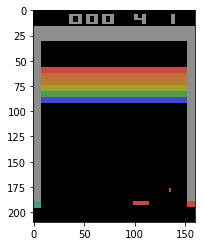

In [7]:
#store = h5py.File('../static/model_rollouts_5.h5','r')
store = h5py.File('../static/model_rollouts_5.h5','r')
ins = store['models_model7-02-17-20-41/model.40.tar/history/0/ins'].value
#store.close()
f = plt.figure(figsize=[3,3*1.3])
# frame_ix = 1404
frame_ix= 10
plt.imshow(ins[frame_ix])
#for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)

In [7]:
store = h5py.File('../static/model_rollouts_5.h5','r')
list(store['models_model7-02-17-20-41/model.40.tar/history/0'].keys())

['actor_sal', 'critic_sal', 'hx', 'ins', 'logits', 'outs', 'values']

In [17]:
store['models_model7-02-17-20-41/model.30.tar/history/0/logits'].value

array([[ 0.6171101 ,  0.93107176,  0.34967324,  0.37195736],
       [-0.0814371 ,  0.8754672 ,  0.76275307,  0.9137547 ],
       [ 0.20477688,  1.0715227 ,  0.19379662,  1.0601748 ],
       ...,
       [ 0.89711624,  0.313035  ,  0.2580776 , -0.6223568 ],
       [ 0.24844502,  0.30964273, -0.24521387,  1.5901337 ],
       [ 0.29520127,  0.9575248 ,  0.80380154,  0.538906  ]],
      dtype=float32)

In [18]:
store['models_model7-02-17-20-41/model.30.tar/history/0/outs'].value

array([[0.255313  , 0.34948197, 0.19540092, 0.19980414],
       [0.11580829, 0.30152124, 0.2693809 , 0.31328958],
       [0.14879744, 0.3540123 , 0.14717254, 0.35001773],
       ...,
       [0.4339817 , 0.24199599, 0.22905533, 0.09496698],
       [0.15386993, 0.16358052, 0.0939205 , 0.58862907],
       [0.17011946, 0.3299115 , 0.28290218, 0.2170669 ]], dtype=float32)

In [19]:
store['models_model7-02-17-20-41/model.30.tar/history/0/values'].value

array([[1.6444745],
       [1.8036902],
       [1.7347144],
       ...,
       [2.150447 ],
       [1.9666785],
       [1.7569826]], dtype=float32)

In [20]:
x = store['models_model7-02-17-20-41/model.30.tar/history/0/logits'].value

In [26]:
F.softmax(torch.from_numpy(x)).numpy()

array([[0.255313  , 0.34948197, 0.19540092, 0.19980414],
       [0.11580829, 0.30152124, 0.2693809 , 0.31328958],
       [0.14879744, 0.3540123 , 0.14717254, 0.35001773],
       ...,
       [0.4339817 , 0.24199599, 0.22905533, 0.09496698],
       [0.15386993, 0.16358052, 0.0939205 , 0.58862907],
       [0.17011946, 0.3299115 , 0.28290218, 0.2170669 ]], dtype=float32)

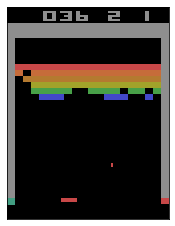

In [30]:
#store = h5py.File('../static/model_rollouts_5.h5','r')
store = h5py.File('../static/model_rollouts_5.h5','r')
ins = store['models_model7-02-17-20-41/model.30.tar/history/0/ins'].value
#store.close()
f = plt.figure(figsize=[3,3*1.3])
# frame_ix = 1404
frame_ix= 1000
plt.imshow(ins[frame_ix])
for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)


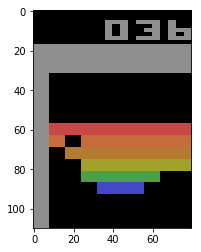

In [44]:
plt.imshow(ins[1000][:110, :80])

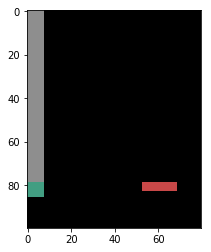

In [45]:
plt.imshow(ins[1000][110:, :80])

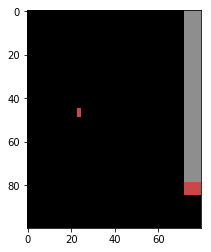

In [46]:
plt.imshow(ins[1000][110:, 80:])

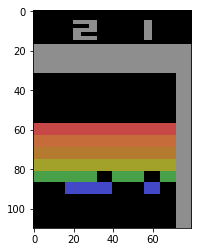

In [47]:
plt.imshow(ins[1000][:110, 80:])

In [29]:
x = store['models_model7-02-17-20-41/model.30.tar/history/0/logits'].value
F.softmax(torch.from_numpy(x)).numpy()[1000]

array([0.2404224, 0.2525917, 0.2200486, 0.2869373], dtype=float32)

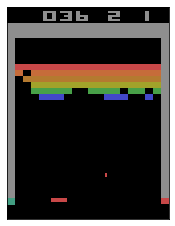

In [28]:
#store = h5py.File('../static/model_rollouts_5.h5','r')
store = h5py.File('../static/model_rollouts_5.h5','r')
ins = store['models_model7-02-17-20-41/model.30.tar/history/0/ins'].value
#store.close()
f = plt.figure(figsize=[3,3*1.3])
# frame_ix = 1404
frame_ix= 1001
plt.imshow(ins[frame_ix])
for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)


## Get Jacobian saliency map

In [29]:
def jacobian(model, layer, top_dh, X):
    global top_h_ ; top_h_ = None
    def hook_top_h(m, i, o): global top_h_ ; top_h_ = o.clone()
    hook1 = layer.register_forward_hook(hook_top_h)
    _ = model(X) # do a forward pass so the forward hooks can be called

    # backprop positive signal
    torch.autograd.backward(top_h_, top_dh.clone(), retain_graph=True) # backward hooks are called here
    #torch.autograd.backward(top_h_, top_dh.clone())
    hook1.remove()
    return X[0].grad.data.clone().numpy(), X[0].data.clone().numpy()

# derivative is simply the output policy distribution
top_dh_actor = torch.Tensor(history['logits'][frame_ix]).view(1,-1)
top_dh_critic = torch.Tensor(history['values'][frame_ix]).view(1,-1).fill_(1)
print(top_dh_actor)
print(top_dh_critic)
print(torch.Tensor(history['values'][frame_ix]).view(1,-1).fill_(2))
top_dh_critic = torch.tensor([[1., 1., 1., 1.]])
# get input
tens_state = torch.Tensor(prepro(history['ins'][frame_ix]))
state = Variable(tens_state.unsqueeze(0), requires_grad=True)
hx = Variable(torch.Tensor(history['hx'][frame_ix-1]).view(1,-1))
#cx = Variable(torch.Tensor(history['cx'][frame_ix-1]).view(1,-1))
#X = (state, (hx, cx))
X = (state, hx)

actor_jacobian, _ = jacobian(model, model.actor_linear, top_dh_actor, X)

state.grad.mul_(0) ; X = (state, hx)
critic_jacobian, _ = jacobian(model, model.critic_linear, top_dh_critic, X)

tensor([[5.6098, 5.9915, 7.3857, 4.6897]])
tensor([[1.]])
tensor([[2.]])


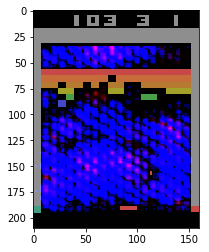

In [30]:
# upsample jacobian saliencies
frame = history['ins'][frame_ix].squeeze().copy()
frame = saliency_on_atari_frame((actor_jacobian**2).squeeze(), frame, fudge_factor=1, channel=2, sigma=0)
jacobian_map = saliency_on_atari_frame((critic_jacobian**2).squeeze(), frame, fudge_factor=15, channel=0, sigma=0)

plt.imshow(jacobian_map)

## Get perturbation saliency map

In [4]:
it = 80

store = h5py.File('../static/model_rollouts.h5','r')
rollout = store['models_model7-02-17-20-41/model.'+str(it)+'.tar/history']

meta = get_env_meta(env_name)
env = gym.make(env_name) ; env.seed(1)

model = NNPolicy(channels=1, num_actions=env.action_space.n, memsize=256)
model.try_load(load_dir, checkpoint='*'+str(it)+'.tar') ; torch.manual_seed(1)
history =  rollout


	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.80.tar


In [5]:
def score_frame(model, history, ix, r, d, interp_func, mode='actor'):
    # r: radius of blur
    # d: density of scores (if d==1, then get a score for every pixel...
    #    if d==2 then every other, which is 25% of total pixels for a 2D image)
    assert mode in ['actor', 'critic'], 'mode must be either "actor" or "critic"'
    L = run_through_model(model, history, ix, interp_func, mask=None, mode=mode)
    
    scores = np.zeros((int(80/d)+1,int(80/d)+1)) # saliency scores S(t,i,j)
    for i in range(0,80,d):
        for j in range(0,80,d):
            mask = get_mask(center=[i,j], size=[80,80], r=r)
            l = run_through_model(model, history, ix, interp_func, mask=mask, mode=mode)
            #print((L-l).pow(2).sum().mul_(.5).item())
            #scores[int(i/d),int(j/d)] = (L-l).pow(2).sum().mul_(.5).data[0]
            scores[int(i/d),int(j/d)] = (L-l).pow(2).sum().mul_(.5).item()
    pmax = scores.max()
    scores = imresize(scores, size=[80,80], interp='bilinear').astype(np.float32)
    return pmax * scores / scores.max()

In [6]:
radius = 5
density = 5
frame_ix = 1800

actor_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='actor')
critic_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='critic')

In [7]:
# upsample perturbation saliencies
frame_ix = 1800

frame = history['ins'][frame_ix].squeeze().copy()
actor_map = saliency_on_atari_frame(actor_saliency, frame, fudge_factor=100, channel=2)
critic_map = saliency_on_atari_frame(critic_saliency, frame, fudge_factor=5000, channel=0)
perturbation_map = saliency_on_atari_frame(critic_saliency, actor_map, fudge_factor=5000, channel=0)

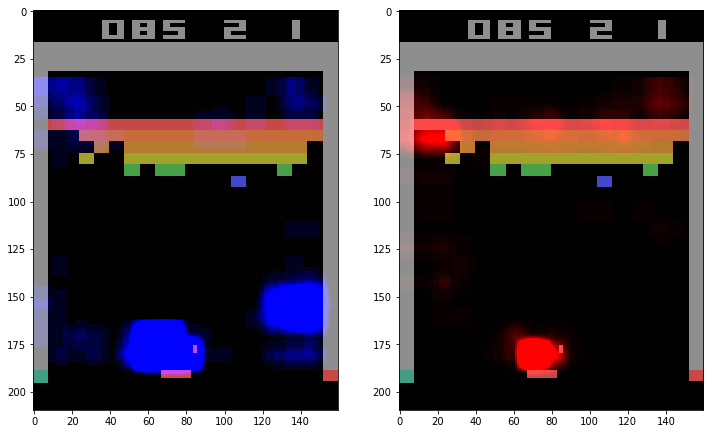

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,12))
axs[0].imshow(actor_map)
axs[1].imshow(critic_map)

In [25]:
sigma = 0
fudge_factor = 100
S = actor_saliency
pmax = actor_saliency.max()
S = imresize(actor_saliency, size=[160,160], interp='bilinear').astype(np.float32)
S = S if sigma == 0 else gaussian_filter(S, sigma=sigma)
S -= S.min() ; S = fudge_factor*pmax * S / S.max()
S

array([[98.67835, 98.67835, 98.67835, ...,  0.     ,  0.     ,  0.     ],
       [98.67835, 98.67835, 98.67835, ...,  0.     ,  0.     ,  0.     ],
       [98.67835, 98.67835, 98.67835, ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ]],
      dtype=float32)

In [32]:
actor_saliency[:3, :10]

array([[1.0195398, 1.0195398, 1.0195398, 1.0195398, 1.3593864, 1.3593864,
        1.6992329, 1.6992329, 1.6992329, 1.3593864],
       [1.0195398, 1.0195398, 1.0195398, 1.0195398, 1.3593864, 1.3593864,
        1.6992329, 1.6992329, 1.6992329, 1.3593864],
       [1.0195398, 1.0195398, 1.0195398, 1.0195398, 1.3593864, 1.3593864,
        1.6992329, 1.6992329, 1.6992329, 1.3593864]], dtype=float32)

In [33]:
S = imresize(actor_saliency, size=[160,160], interp='bilinear').astype(np.float32)
S[:3, :10]

array([[3., 3., 3., 3., 3., 3., 3., 3., 4., 4.],
       [3., 3., 3., 3., 3., 3., 3., 3., 4., 4.],
       [3., 3., 3., 3., 3., 3., 3., 3., 4., 4.]], dtype=float32)

In [17]:
actor_map[:,:,0].shape

(210, 160)

In [20]:
actor_map[:,:,0][:110, :80]


550576

In [21]:
actor_map[:,:,0].sum()

1364512

In [60]:
def saliency_on_atari_frame(saliency, atari, fudge_factor, channel=2, sigma=0):
    # sometimes saliency maps are a bit clearer if you blur them
    # slightly...sigma adjusts the radius of that blur
    pmax = saliency.max()
    S = imresize(saliency, size=[160,160], interp='bilinear').astype(np.float32)
    S = S if sigma == 0 else gaussian_filter(S, sigma=sigma)
    S -= S.min() ; S = fudge_factor*pmax * S / S.max()

    I = atari.astype('uint16')
    I[35:195,:,channel] += S.astype('uint16')
    I = I.clip(1,255).astype('uint8')
    return I

actor_saliency.shape

(80, 80)

# gen saliency maps and save 

In [53]:
store = h5py.File('model_rollouts.h5','r')

present = [i for i in range(1,100)]
for i in list(store[list(store.keys())[0]].keys()):
    num = int(i.split('.')[-2])
    if num in present:
        present.remove(num)
present

[15, 20]

In [55]:
store = h5py.File('../static/model_rollouts_5.h5','r')

actor_saliency.shape

if not os.path.exists('images'):
    os.makedirs('images')
eps = 5 # number of episodes to replay per model

for iteration in [1, 10, 19, 30, 40, 50, 60, 70, 80, 90, 100]:
    print("running iteration ",iteration)
    
    if iteration==15 or iteration==20: # bad hot fix for now 
        continue
    ins = store['models_model7-02-17-20-41/model.'+str(iteration)+'.tar/history/0/ins'].value
    hx = store['models_model7-02-17-20-41/model.'+str(iteration)+'.tar/history/0/hx'].value
    for ep in range(eps):
        
        history = {'ins':ins, 'hx':hx}

        meta = get_env_meta(env_name)
        env = gym.make(env_name) ; env.seed(1)
        model = NNPolicy(channels=1, num_actions=env.action_space.n, memsize=256)
        try:
            _ = model.try_load(load_dir, checkpoint='*.'+str(iteration)+'.tar') ; torch.manual_seed(ep+1)
        except:
            print("exception at iteration: ",iteration)
            continue

        folder = os.path.join('images',str(iteration))

        if not os.path.exists(folder):
            os.makedirs(folder)

        radius = 5
        density = 5

        for frame_ix in [500, 1000, 1500, 2000, 2500]:
            if frame_ix >= len(history['ins']):
                break
            actor_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='actor')
            critic_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='critic')
            frame = history['ins'][frame_ix].squeeze().copy()
            frame = saliency_on_atari_frame(actor_saliency, frame, fudge_factor=200, channel=2)
            perturbation_map = saliency_on_atari_frame(critic_saliency, frame, fudge_factor=100, channel=0)

            plt.imsave(os.path.join(folder, str(frame_ix)), perturbation_map)    
            print("saved {}th frame & sal-map", frame_ix)

running iteration  15
running iteration  16
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.16.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
running iteration  17
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.17.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
running iteration  18
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.18.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
saved {}th frame & sal-map 2500
running iteration  19
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.19.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
running iteration  20
running iteration  21
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.21.tar
saved {}th frame & sal-map 500
saved {}th fr

saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
saved {}th frame & sal-map 2500
running iteration  58
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.58.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
running iteration  59
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.59.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
running iteration  60
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.60.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
running iteration  61
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.61.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 15

saved {}th frame & sal-map 1500
running iteration  95
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.95.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
running iteration  96
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.96.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
saved {}th frame & sal-map 2500
running iteration  97
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.97.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
running iteration  98
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.98.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
saved {}th frame & sal-map 2500
running iteration  99
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model

## Plot side-by-side

NameError: name 'jacobian_map' is not defined

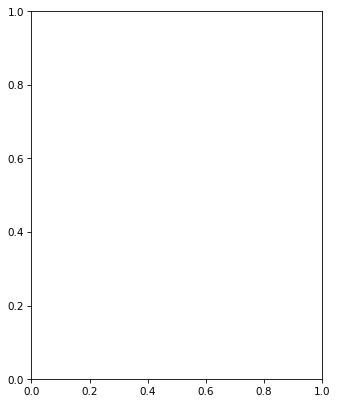

In [13]:
f = plt.figure(figsize=[11, 5*1.3], dpi=75)

plt.subplot(1,2,1)
plt.imshow(jacobian_map)
plt.title('Jacobian', fontsize=30)

plt.subplot(1,2,2)
plt.imshow(perturbation_map)
plt.title('Ours', fontsize=30)

for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)
plt.show() #; f.savefig('./figures/jacobian-vs-perturb.png', bbox_inches='tight')